**Import libraries**

In [56]:
"""
Neural Networks (Dr. Shakeri)
Bonus Project 1 (TA):
    - Implementing GANs
Student Name and ID: Pouria Alimoradpor 9912035
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.utils import save_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

<div dir="rtl">
### توضیحات مدل تولیدکننده (Generator)

مدل تولیدکننده یا Generator در اینجا وظیفه دارد که از یک بردار تصادفی (که به آن بردار نهفته یا z گفته می‌شود) تصاویر دست‌نویس را تولید کند. این مدل از لایه‌های ConvTranspose2d استفاده می‌کند که برای افزایش ابعاد تصویر به کار می‌روند (Upsampling). توضیحات کامل بخش‌های مختلف این مدل به شرح زیر است:

1. **ورودی بردار نهفته (z_dim)**:
   - بردار نهفته به عنوان ورودی به مدل داده می‌شود که به عنوان نویز تصادفی عمل می‌کند.
   
2. **لایه اول ConvTranspose2d**:
   - این لایه بردار نهفته را به یک ویژگی نقشه 128 کانالی با ابعاد 7x7 تبدیل می‌کند. 
   - **BatchNorm2d**: این لایه به نرمال‌سازی دسته‌ای کمک می‌کند تا فرآیند یادگیری پایدارتر شود.
   - **ReLU**: تابع فعال‌سازی که به مدل کمک می‌کند تا ویژگی‌های پیچیده‌تری را یاد بگیرد.

3. **لایه دوم ConvTranspose2d**:
   - این لایه ویژگی نقشه را به ابعاد 14x14 افزایش می‌دهد.
   - **BatchNorm2d**: نرمال‌سازی دسته‌ای برای پایداری.
   - **ReLU**: تابع فعال‌سازی.

4. **لایه سوم ConvTranspose2d**:
   - این لایه ویژگی نقشه را به ابعاد 28x28 افزایش می‌دهد و خروجی نهایی تصویر تولید شده را ارائه می‌دهد.
   - **Tanh**: تابع فعال‌سازی که خروجی را به محدوده [-1, 1] محدود می‌کند که مناسب برای تصاویر نرمال شده است.

### توضیحات مدل تمیزدهنده (Discriminator)

مدل تمیزدهنده یا Discriminator وظیفه دارد که تشخیص دهد آیا تصویر ورودی واقعی است یا توسط تولیدکننده تولید شده است. این مدل از لایه‌های Conv2d استفاده می‌کند که برای کاهش ابعاد تصویر به کار می‌روند (Downsampling). توضیحات کامل بخش‌های مختلف این مدل به شرح زیر است:

1. **ورودی تصویر (img_dim)**:
   - ورودی به مدل یک تصویر 28x28 تک کانالی است (تصویر خاکستری).

2. **لایه اول Conv2d**:
   - این لایه تصویر ورودی را به یک ویژگی نقشه 64 کانالی با ابعاد 14x14 کاهش می‌دهد.
   - **LeakyReLU**: تابع فعال‌سازی که از مرگ نورون‌ها جلوگیری می‌کند و اجازه می‌دهد که گرادیان‌های منفی هم عبور کنند.

3. **لایه دوم Conv2d**:
   - این لایه ویژگی نقشه را به ابعاد 7x7 کاهش می‌دهد.
   - **BatchNorm2d**: نرمال‌سازی دسته‌ای برای پایداری.
   - **LeakyReLU**: تابع فعال‌سازی.

4. **لایه سوم Conv2d**:
   - این لایه ویژگی نقشه را به یک مقدار تک خروجی کاهش می‌دهد که نشان‌دهنده احتمال واقعی بودن تصویر است.
   - **Sigmoid**: تابع فعال‌سازی که خروجی را به محدوده [0, 1] محدود می‌کند که به عنوان احتمال واقعی بودن تصویر تفسیر می‌شود.
</div>

In [57]:
# Define the Generator model
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is the latent vector z
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Upsampling to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Upsampling to 28x28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )        

    def forward(self, z):
        return self.main(z)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is a 28x28 grayscale image
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.main(img)

<div dir="rtl">

#### تنظیمات دستگاه (Device)
ابتدا دستگاهی که برای محاسبات استفاده خواهد شد تعیین می‌شود. اگر GPU در دسترس باشد، از `cuda` استفاده می‌شود و در غیر این صورت از `cpu`.

#### تنظیمات هایپرپارامترها (Hyperparameters)
در این بخش هایپرپارامترهای مختلفی تعریف می‌شوند که شامل موارد زیر هستند:
- `latent_dim`: ابعاد بردار نویز (z) که به عنوان ورودی به تولیدکننده داده می‌شود.
- `batch_size`: اندازه دسته‌های داده برای آموزش.
- `num_epochs`: تعداد کل دورهای آموزش.
- `lr`: نرخ یادگیری برای بهینه‌سازها.

#### آماده‌سازی داده‌ها (Data Preparation)
در این بخش داده‌های مجموعه MNIST بارگذاری و پیش‌پردازش می‌شوند:
- داده‌ها به تنسور تبدیل می‌شوند و سپس نرمال‌سازی می‌شوند به گونه‌ای که مقادیر بین [-1, 1] قرار بگیرند.
- داده‌های آموزش به همراه تغییرات لازم دانلود و بارگذاری می‌شوند.
- `DataLoader` برای فراهم کردن دسته‌های داده‌ای که به مدل وارد می‌شوند استفاده می‌شود.

#### مقداردهی اولیه مدل‌ها، تابع هزینه و بهینه‌سازها (Initialize Models, Loss Function, and Optimizers)
- **مدل‌ها**: تولیدکننده و تمیزدهنده با استفاده از ابعاد مشخص‌شده مقداردهی اولیه می‌شوند و به دستگاه مورد نظر منتقل می‌شوند.
- **تابع هزینه**: از تابع هزینه `BCELoss` (خطای باینری متقاطع) برای محاسبه میزان خطا استفاده می‌شود.
- **بهینه‌سازها**: دو بهینه‌ساز Adam برای تولیدکننده (`optimizer_g`) و تمیزدهنده (`optimizer_d`) با نرخ یادگیری و مقادیر `betas` مشخص تعریف می‌شوند.

این بخش کد به تنظیم و آماده‌سازی مدل‌ها، داده‌ها و تنظیمات مورد نیاز برای شروع آموزش شبکه‌های مولد تخاصمی (GAN) می‌پردازد.

### دلیل استفاده از BCE (Binary Cross Entropy)

در شبکه‌های مولد تخاصمی (GAN)، هدف اصلی این است که تمیزدهنده (Discriminator) یاد بگیرد که تصاویر واقعی را از تصاویر تقلبی (تولید شده توسط تولیدکننده) تشخیص دهد. برای این منظور، از تابع خطای باینری متقاطع (Binary Cross Entropy) استفاده می‌شود که به شرح زیر است:

#### تعریف تابع خطای باینری متقاطع

تابع خطای باینری متقاطع برای مسائل طبقه‌بندی باینری طراحی شده است. این تابع محاسبه می‌کند که چقدر پیش‌بینی‌های مدل به برچسب‌های واقعی نزدیک هستند. فرمول تابع خطای باینری متقاطع به شکل زیر است:
</div>

\[ \text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i)] \]

<div dir="rtl">

- \( y_i \): برچسب واقعی (0 برای تصاویر تقلبی و 1 برای تصاویر واقعی)
- \( p_i \): احتمال پیش‌بینی شده توسط مدل برای اینکه تصویر واقعی باشد
- \( N \): تعداد نمونه‌ها

#### مزایا
- **سادگی**: تابع خطای باینری متقاطع ساده است و به راحتی قابل پیاده‌سازی و محاسبه است.
- **کارایی**: این تابع به خوبی برای مسائل طبقه‌بندی باینری مناسب است و در تنظیمات GAN بسیار موثر عمل می‌کند.
- **تفسیرپذیری**: خروجی تابع خطا به صورت احتمالی بین 0 و 1 تفسیر می‌شود که می‌تواند به راحتی با مقادیر برچسب‌ها مقایسه شود.

بنابراین، استفاده از تابع خطای باینری متقاطع در GAN به دلیل سازگاری با هدف تمیزدهنده و تولیدکننده و همچنین کارایی و سادگی آن توصیه می‌شود.

</div>

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100    # Dimension of the noise vector z
batch_size = 64
num_epochs = 15
lr = 0.0002

In [64]:
# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize models, loss function and optimizers
generator = Generator(latent_dim, 28*28).to(device)
discriminator = Discriminator(28*28).to(device)
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

<div dir="rtl">

#### حلقه آموزش (Training Loop)
حلقه‌ی آموزش اصلی شامل سه بخش عمده است: آموزش تمیزدهنده (Discriminator)، آموزش تولیدکننده (Generator) و ذخیره‌ی تصاویر تولید شده.

##### توابع مورد استفاده
- **train**: این تابع مسئولیت اجرای فرآیند آموزش را برعهده دارد.
- **save_generated_images**: این تابع برای ذخیره‌ی تصاویر تولید شده توسط تولیدکننده در هر دوره (epoch) استفاده می‌شود.

#### آموزش تمیزدهنده (Discriminator)
تمیزدهنده باید تصاویر واقعی را از تصاویر تقلبی تشخیص دهد. در هر مرحله از آموزش:
1. **بازنشانی گرادیان‌ها**: قبل از محاسبه‌ی گرادیان‌ها باید گرادیان‌ها به صفر تنظیم شوند.
2. **آموزش با تصاویر واقعی**: تصاویر واقعی به تمیزدهنده داده می‌شوند و خروجی آن با برچسب‌های واقعی (1) مقایسه می‌شود.
3. **آموزش با تصاویر تقلبی**: تصاویر تقلبی توسط تولیدکننده تولید می‌شوند و به تمیزدهنده داده می‌شوند. خروجی تمیزدهنده با برچسب‌های تقلبی (0) مقایسه می‌شود.
4. **محاسبه و به‌روزرسانی گرادیان‌ها**: مجموع خطاها محاسبه و گرادیان‌ها به‌روزرسانی می‌شوند.

##### آموزش تولیدکننده (Generator)
تولیدکننده باید یاد بگیرد که تصاویر تقلبی تولید کند که تمیزدهنده نتواند آن‌ها را از تصاویر واقعی تشخیص دهد. در هر مرحله از آموزش:
1. **بازنشانی گرادیان‌ها**: قبل از محاسبه‌ی گرادیان‌ها باید گرادیان‌ها به صفر تنظیم شوند.
2. **تولید تصاویر تقلبی**: نویز (z) به تولیدکننده داده می‌شود و تصاویر تقلبی تولید می‌شوند.
3. **ارزیابی تمیزدهنده**: تمیزدهنده بر روی تصاویر تقلبی اعمال می‌شود و خروجی آن با برچسب‌های واقعی (1) مقایسه می‌شود.
4. **محاسبه و به‌روزرسانی گرادیان‌ها**: خطای تولیدکننده محاسبه و گرادیان‌ها به‌روزرسانی می‌شوند.

##### ذخیره‌سازی تصاویر تولید شده (Saving Generated Images)
در پایان هر دوره (epoch)، تصاویر تولید شده توسط تولیدکننده ذخیره می‌شوند تا بتوان روند بهبود عملکرد تولیدکننده را مشاهده کرد.

تابع `save_generated_images` به ذخیره‌سازی تصاویر تولید شده در مسیر مشخص شده کمک می‌کند.

</div>

In [65]:
# Define training loop
def train(train_loader, discriminator, generator, criterion, optimizer_d, optimizer_g, latent_dim, num_epochs):
    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)

            # Train with real images
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_labels)
            d_loss_real.backward()

            # Train with fake images
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_imgs = generator(z)
            output = discriminator(fake_imgs)
            g_loss = criterion(output, real_labels)
            g_loss.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

        # Save generated images for visualization
        save_generated_images(fake_imgs, epoch+1)

def save_generated_images(images, epoch, path='./results'):
    if not os.path.exists(path):
        os.makedirs(path)
    save_image(images, os.path.join(path, f'epoch_{epoch}.png'), nrow=8, normalize=True)

In [66]:
train(train_loader, discriminator, generator, criterion, optimizer_d, optimizer_g, latent_dim, num_epochs)

Epoch [1/15], Step [0/938], D_loss: 1.2665, G_loss: 1.0563
Epoch [1/15], Step [100/938], D_loss: 0.0069, G_loss: 5.7940
Epoch [1/15], Step [200/938], D_loss: 0.0047, G_loss: 6.0800
Epoch [1/15], Step [300/938], D_loss: 0.0018, G_loss: 7.0143
Epoch [1/15], Step [400/938], D_loss: 0.0008, G_loss: 8.0563
Epoch [1/15], Step [500/938], D_loss: 0.5173, G_loss: 3.3223
Epoch [1/15], Step [600/938], D_loss: 0.7365, G_loss: 1.3844
Epoch [1/15], Step [700/938], D_loss: 0.9550, G_loss: 2.1844
Epoch [1/15], Step [800/938], D_loss: 0.7274, G_loss: 1.2087
Epoch [1/15], Step [900/938], D_loss: 0.6532, G_loss: 2.0715
Epoch [2/15], Step [0/938], D_loss: 0.5767, G_loss: 1.4475
Epoch [2/15], Step [100/938], D_loss: 0.6730, G_loss: 0.9661
Epoch [2/15], Step [200/938], D_loss: 0.6156, G_loss: 1.7225
Epoch [2/15], Step [300/938], D_loss: 0.6050, G_loss: 2.2257
Epoch [2/15], Step [400/938], D_loss: 0.6497, G_loss: 2.3064
Epoch [2/15], Step [500/938], D_loss: 0.5682, G_loss: 1.7163
Epoch [2/15], Step [600/938]

<div dir="rtl">
در این بخش کد، فرآیند بصری‌سازی نتایج تولیدشده توسط شبکه مولد (Generator) طی مراحل آموزش را توضیح می‌دهیم. این کد تصاویر تولید شده در هر دوره (epoch) آموزش را نمایش می‌دهد تا بتوانیم پیشرفت تولید تصاویر را مشاهده کنیم.
</div>

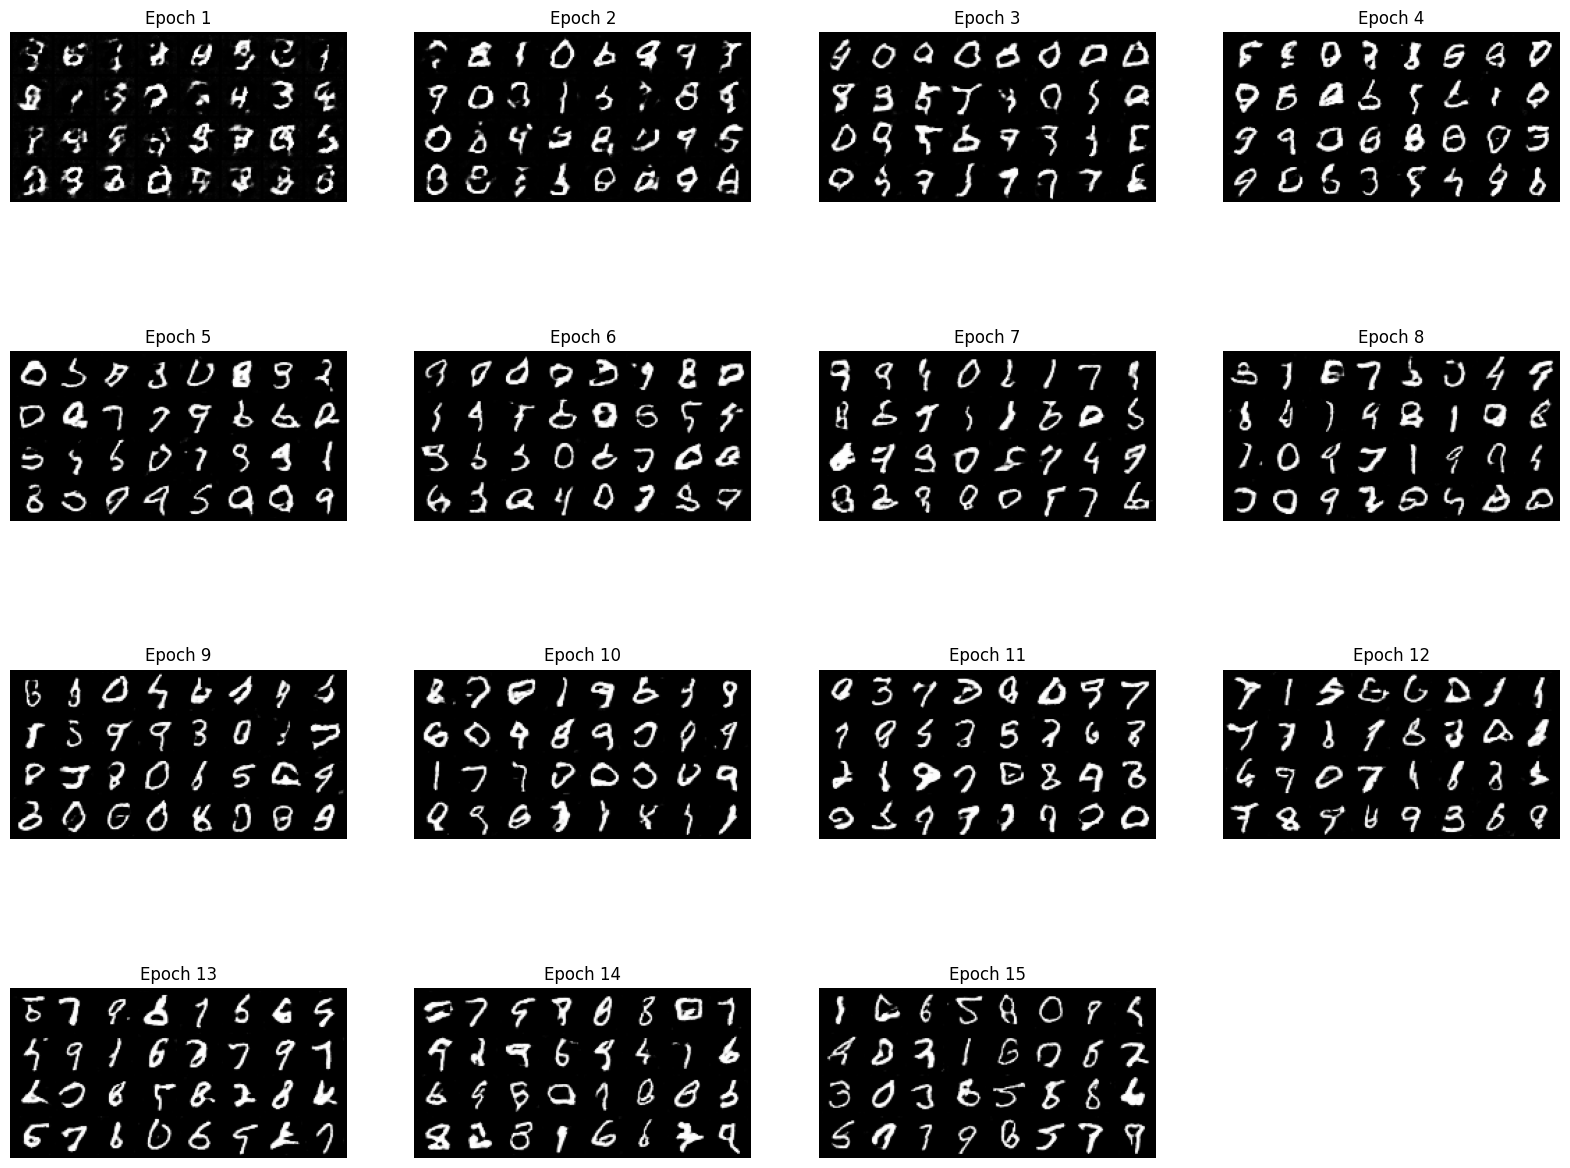

In [67]:
# Visualization (All generated images)
def visualize_results():
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, num_epochs+1):
        img = plt.imread(f'./results/epoch_{i}.png')
        fig.add_subplot(5, 4, i)
        plt.title(f'Epoch {i}')
        plt.imshow(img)
        plt.axis('off')
    plt.show()
        
visualize_results()

<div dir="rtl">
حال که شبکه Generator به خوبی در 15 ایپاک آموزش داده شده، میتوان خروجی آنرا مانند سایت 
<a url=\"https://thispersondoesnotexist.com\">
thispersondoesnotexist</a>
تست کرد.
</div>

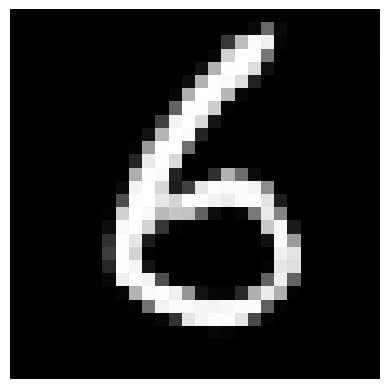

In [148]:
# Generate one final fake Hand-write digit with my Generator
z = torch.randn(1, latent_dim, 1, 1).to(device)
fake_img = generator(z)

# Show
fake_img = fake_img.view(28, 28).cpu().detach().numpy()
plt.imshow(fake_img, cmap='gray')
plt.axis('off')
plt.show()